# Tolkien character or prescription drug?
## Classification using character-level LSTM neural networks

## Dataset

### Tolkien characters

In [1]:
import pandas as pd

raw_tolkien_chars = pd.read_html('https://www.behindthename.com/namesakes/list/tolkien/name')
raw_tolkien_chars[2].head()

,Name,Gender,Details,Total
0,Adalbert,m,1 character,1
1,Adaldrida,f,1 character,1
2,Adalgar,m,1 character,1
3,Adalgrim,m,1 character,1
4,Adamanta,f,1 character,1


In [2]:
tolkien_names = raw_tolkien_chars[2]['Name']
tolkien_names.iloc[350:355]

350           Gethron
351    Ghân-buri-Ghân
352            Gildis
353            Gildor
354         Gil-galad
Name: Name, dtype: object

Preprocess names to transform unicode characters into ASCII, remove punctuation marks and transform to lowercase

In [3]:
import unidecode

processed_tolkien_names = tolkien_names.apply(unidecode.unidecode).str.lower().str.replace('-', ' ')
processed_tolkien_names = [name[0] for name in processed_tolkien_names.str.split()]
processed_tolkien_names = pd.DataFrame(processed_tolkien_names, columns=['name']).sort_values('name').drop_duplicates()
processed_tolkien_names['tolkien'] = 1

In [4]:
processed_tolkien_names['name'].iloc[350:355]

350    gethron
351       ghan
354        gil
352     gildis
353     gildor
Name: name, dtype: object

In [5]:
processed_tolkien_names.shape

(746, 2)

### Prescription drugs

In [6]:
raw_medication_guide = pd.read_csv('data/raw/medication_guides.csv')
raw_medication_guide.head()

,Drug Name,Active Ingredient,Form;Route,Appl. No.,Company,Date,Link
0,Abilify,Aripiprazole,"TABLET, ORALLY DISINTEGRATING;ORAL",21729,OTSUKA,02/05/2020,https://www.accessdata.fda.gov/drugsatfda_docs...
1,Abilify,Aripiprazole,TABLET;ORAL,21436,OTSUKA,02/05/2020,https://www.accessdata.fda.gov/drugsatfda_docs...
2,Abilify,Aripiprazole,SOLUTION;ORAL,21713,OTSUKA,02/05/2020,https://www.accessdata.fda.gov/drugsatfda_docs...
3,Abilify,Aripiprazole,SOLUTION;ORAL,21713,OTSUKA,02/05/2020,https://www.accessdata.fda.gov/drugsatfda_docs...
4,Abilify,Aripiprazole,INJECTABLE;INTRAMUSCULAR,21866,OTSUKA,02/05/2020,https://www.accessdata.fda.gov/drugsatfda_docs...


In [7]:
drug_names = raw_medication_guide['Drug Name']
drug_names.iloc[160:165]

160                                             Chantix
161         Children's Cetirizine Hydrochloride Allergy
162    Chlordiazepoxide and Amitriptyline Hydrochloride
163                                              Cimzia
164                                              Cimzia
Name: Drug Name, dtype: object

Preprocess names to remove punctuation marks and transform to lowercase

In [8]:
processed_drug_names = drug_names.str.lower().str.replace('.', '').str.replace( '-', ' ').str.replace('/', ' ').str.replace("'", ' ').str.replace(",", ' ')
processed_drug_names = [name[0] for name in processed_drug_names.str.split()]
processed_drug_names = pd.DataFrame(processed_drug_names, columns=['name']).sort_values('name').drop_duplicates()
processed_drug_names['tolkien'] = 0

In [9]:
processed_drug_names['name'].iloc[84:89]

160             chantix
161            children
162    chlordiazepoxide
166              cimzia
175               cipro
Name: name, dtype: object

In [10]:
processed_drug_names.shape

(611, 2)

In [11]:
dataset = pd.concat([processed_tolkien_names, processed_drug_names], ignore_index=True)
dataset.to_csv('data/processed/dataset.csv', index=False, header=True)
dataset.head()

,name,tolkien
0,adalbert,1
1,adaldrida,1
2,adalgar,1
3,adalgrim,1
4,adamanta,1


## Data transformation

In [12]:
import pandas as pd
dataset = pd.read_csv('data/processed/dataset.csv')

from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(dataset['name'])
char_index = tokenizer.texts_to_sequences(dataset['name'])

print(dataset['name'][134])
print(char_index[134])

Using TensorFlow backend.


bilbo
[16, 3, 6, 16, 5]


Each letter is represented by an integer

In [13]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np

char_index = pad_sequences(char_index, maxlen=dataset['name'].apply(len).max(), padding="post")
x = to_categorical(char_index)  # onehot encoding
y = np.array(dataset['tolkien'])

print(x[134])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

Now each letter/integer is represented by a one-hot encoded vector.

The vector consists of 0s in all cells with the exception of a single 1 in a cell to identify the letter.

In [14]:
x.shape

(1357, 17, 27)

In [15]:
print(f"There are {x.shape[0]} words. Each word has {x.shape[1]} letters and each letter is represented by an one-hot encoded vector of size {x.shape[2]}.")

There are 1357 words. Each word has 17 letters and each letter is represented by an one-hot encoded vector of size 27.


## Data split

In [16]:
from sklearn.model_selection import train_test_split

def data_split(data, labels, train_ratio=0.5, rand_seed=42):

    x_train, x_temp, y_train, y_temp = train_test_split(data,
                                                        labels,
                                                        train_size=train_ratio,
                                                        random_state=rand_seed)

    x_val, x_test, y_val, y_test = train_test_split(x_temp,
                                                    y_temp,
                                                    train_size=0.5,
                                                    random_state=rand_seed)

    return x_train, x_val, x_test, y_train, y_val, y_test

x_train, x_val, x_test, y_train, y_val, y_test = data_split(x, y, train_ratio=0.6)

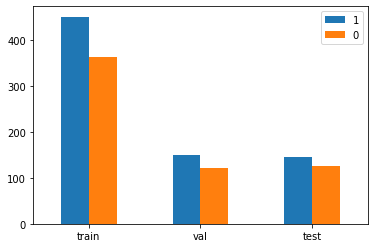

Total number of samples: 
1357
Class/Samples: 
1    746
0    611
dtype: int64
Split/Class/Samples: 
         1    0
train  451  363
val    149  122
test   146  126


In [17]:
from collections import Counter
import matplotlib.pyplot as plt

dataset_count = pd.DataFrame([Counter(y_train), Counter(y_val), Counter(y_test)],
                                index=["train", "val", "test"])
dataset_count.plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

print(f"Total number of samples: \n{dataset_count.sum(axis=0).sum()}")
print(f"Class/Samples: \n{dataset_count.sum(axis=0)}")
print(f"Split/Class/Samples: \n{dataset_count}")

## Model

### Training

In [18]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM
from tensorflow.random import set_seed
set_seed(23)

model = Sequential()
model.add(LSTM(8, return_sequences=False,
               input_shape=(x.shape[1], x.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.add(Activation('sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 1152      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 1,161
Trainable params: 1,161
Non-trainable params: 0
_________________________________________________________________


In [19]:
from tensorflow.keras.optimizers import Adam

model.compile(loss="binary_crossentropy",
              optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', verbose=1, patience=20)
mc = ModelCheckpoint("best_model.h5", monitor='val_loss',
                     verbose=1, save_best_only=True)

history = model.fit(x_train, y_train, batch_size=32, epochs=100,
                    validation_data=(x_val, y_val), callbacks=[es, mc])

Epoch 1/100
26/26 [==============================] - 5s 81ms/step - loss: 0.6832 - accuracy: 0.5750 - val_loss: 0.6864 - val_accuracy: 0.5535

Epoch 00001: val_loss improved from inf to 0.68640, saving model to best_model.h5
Epoch 2/100
26/26 [==============================] - 0s 17ms/step - loss: 0.6879 - accuracy: 0.5471 - val_loss: 0.6850 - val_accuracy: 0.5535

Epoch 00002: val_loss improved from 0.68640 to 0.68499, saving model to best_model.h5
Epoch 3/100
26/26 [==============================] - 1s 23ms/step - loss: 0.6881 - accuracy: 0.5335 - val_loss: 0.6837 - val_accuracy: 0.5572

Epoch 00003: val_loss improved from 0.68499 to 0.68375, saving model to best_model.h5
Epoch 4/100
26/26 [==============================] - 0s 15ms/step - loss: 0.6845 - accuracy: 0.5408 - val_loss: 0.6812 - val_accuracy: 0.5572

Epoch 00004: val_loss improved from 0.68375 to 0.68123, saving model to best_model.h5
Epoch 5/100
26/26 [==============================] - 0s 17ms/step - loss: 0.6805 - accur

Epoch 39/100
26/26 [==============================] - 1s 41ms/step - loss: 0.4079 - accuracy: 0.8438 - val_loss: 0.3796 - val_accuracy: 0.8155

Epoch 00039: val_loss did not improve from 0.35461
Epoch 40/100
26/26 [==============================] - 1s 35ms/step - loss: 0.3814 - accuracy: 0.8434 - val_loss: 0.3614 - val_accuracy: 0.8487

Epoch 00040: val_loss did not improve from 0.35461
Epoch 41/100
26/26 [==============================] - 1s 31ms/step - loss: 0.3643 - accuracy: 0.8622 - val_loss: 0.3570 - val_accuracy: 0.8487

Epoch 00041: val_loss did not improve from 0.35461
Epoch 42/100
26/26 [==============================] - 1s 26ms/step - loss: 0.3475 - accuracy: 0.8633 - val_loss: 0.3576 - val_accuracy: 0.8303

Epoch 00042: val_loss did not improve from 0.35461
Epoch 43/100
26/26 [==============================] - 1s 26ms/step - loss: 0.3651 - accuracy: 0.8572 - val_loss: 0.3555 - val_accuracy: 0.8413

Epoch 00043: val_loss did not improve from 0.35461
Epoch 44/100
26/26 [=====

In [21]:
val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print(f"Best epoch: {best_epoch}")

Best epoch: 52


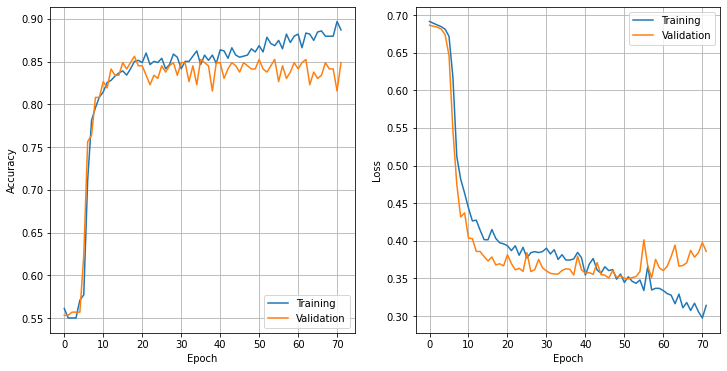

In [22]:
def plot_metrics(history):
    
    plt.figure(figsize=(12,6))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid('on')

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid('on')

plot_metrics(history)

Accuracy value quickly reaches a plateau (+/- 80%).

Model starts overfitting after epoch 50.

## Performance evaluation

In [23]:
from tensorflow.keras.models import load_model

model = load_model("best_model.h5")
metrics = model.evaluate(x=x_test, y=y_test)

9/9 [==============================] - 2s 8ms/step - loss: 0.4595 - accuracy: 0.8125


In [24]:
print("Accuracy: {0:.2f} %".format(metrics[1]*100))

Accuracy: 81.25 %


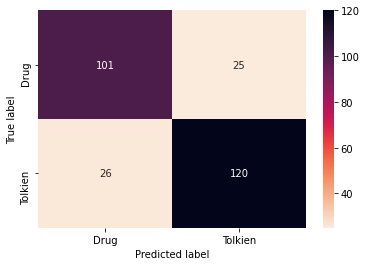

In [25]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

def plot_confusion_matrix(y_true, y_pred, labels):
    
    cm = confusion_matrix(y_true, y_pred)
    heatmap(cm, annot=True, fmt="d", cmap="rocket_r", xticklabels=labels, yticklabels=labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

predictions = model.predict(x_test)
threshold = 0.5
y_pred = predictions > threshold
plot_confusion_matrix(y_test, y_pred, labels=['Drug','Tolkien'])

In [26]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=['Drug', 'Tolkien']))

              precision    recall  f1-score   support

        Drug       0.80      0.80      0.80       126
     Tolkien       0.83      0.82      0.82       146

    accuracy                           0.81       272
   macro avg       0.81      0.81      0.81       272
weighted avg       0.81      0.81      0.81       272



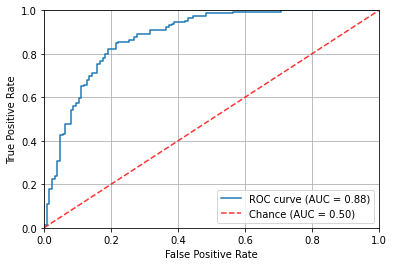

In [27]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, predictions):

    fpr, tpr, thresholds = roc_curve(y_true, predictions)
    auc_value = auc(fpr, tpr)
    plt.plot(fpr, tpr, label="ROC curve (AUC = {0:.2f})".format(auc_value))
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], 'r--', label='Chance (AUC = 0.50)', alpha=.8)
    plt.legend()
    plt.grid('on')
    plt.show()

plot_roc_curve(y_test, predictions)

The model presents good accuracy. Precision and recall are pretty balanced as we can see by the F1-score.

### Which Tolkien characters could pass as prescription drugs?
A.K.A. False Negatives

In [28]:
def onehot_to_text(onehot_word):
    char_index = [[np.argmax(char) for char in onehot_word]]
    word = tokenizer.sequences_to_texts(char_index)
    return ''.join(word[0].split())

In [29]:
test_result = pd.DataFrame()
test_result['true'] = y_test
test_result['prediction'] = y_pred.astype(int)
test_result['name'] = [onehot_to_text(name) for name in x_test]
test_result.head()

,true,prediction,name
0,0,0,supprelin
1,1,1,bingo
2,0,0,ponstel
3,0,1,elidel
4,0,0,aubagio


In [30]:
test_result['name'].loc[(test_result['true']==1) & (test_result['prediction']==0)]

13              ivy
17         camellia
44      celebrindor
47         meriadoc
63        vanimelde
64        finduilas
75        eglantine
84             ruby
87            poppy
89             otto
100           tanta
102          myrtle
108          prisca
132          cottar
151          stybba
171            este
175           daisy
189          tulkas
195        arciryas
205        odovacar
206          tarcil
207    hyarmendacil
229            jago
230            tata
240           ponto
271       landroval
Name: name, dtype: object